# 数据连接和清洗 基于xjsh_data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import Point
import os
import fiona
from pathlib import Path

In [20]:
# 获取文件路径
def find_file_with_string(path, string):
    for root, dirs, files in os.walk(path):
        for file in files:
            if string in file:
                return os.path.join(root, file)
    return None

# 点转shp

def table_to_shp(input_file, output_file, lon_col, lat_col, input_crs=4326, output_crs=4544):
    # 设置fiona支持utf-8编码
    fiona.supported_drivers['ESRI Shapefile'] = 'rw'

    # 读取输入文件,如果是DataFrame，则直接使用  
    if isinstance(input_file, pd.DataFrame):
        df = input_file
    else:
        _, file_extension = os.path.splitext(input_file)
        if file_extension.lower() == '.xlsx':
            df = pd.read_excel(input_file)
        elif file_extension.lower() == '.csv':
            df = pd.read_csv(input_file, encoding='utf-8')
        else:
            raise ValueError(f"Unsupported file type: {file_extension}")

    # 创建几何列
    geometry = [Point(xy) for xy in zip(df[lon_col], df[lat_col])]
    
    # 创建GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=geometry, crs=f"EPSG:{input_crs}")
    
    # 如果需要,转换坐标系
    if input_crs != output_crs:
        gdf = gdf.to_crs(epsg=output_crs)
    
    # 保存为shapefile,使用utf-8编码
    gdf.to_file(output_file, driver="ESRI Shapefile", encoding='utf-8')

    print(f"Shapefile已保存至: {output_file}")


In [3]:
# 基础信息表
base_point = r"F:\collection_spb_info\GJ\KY\base_info_20241218_1598.xlsx"
# 检测信息表
data_point = r"F:\collection_spb_info\XJSH\KY\all_info_20241211_2214.xlsx"

In [4]:
# 点位信息列表
info_list = ['ydbh','dwjd','dwwd','ydlb']
# 理化指标列表
phy_che_list = ['ydbh','yypbh','jcjg','yjz','ph','ylzjhl',
                'qdan','qlin','qjia','qxi',
                'yxlin','sxjia','hxjia','yxliu','yxgui','yxtie','yxmeng','yxtong','yxxing','yxpeng','yxmu','zgong','zshen','zqian','zge','zge2','znie',
                'jxzc11','jxzc12','jxzc13','jxzc14','jxzc1trzd']

In [5]:
# 读取信息
df_base = pd.read_excel(base_point,usecols=info_list)
df_data = pd.read_excel(data_point,usecols=phy_che_list)

In [6]:
# 连接数据表
df_result_data = pd.merge(df_base,df_data,on='ydbh',how='left')

In [7]:
len(pd.unique(df_result_data['ydbh']))

1598

In [8]:
# 删除yypbh列中末尾不以11或10结尾的行
df_result_data['yypbh'] = df_result_data['yypbh'].astype('str')
df_result_data = df_result_data[df_result_data['yypbh'].str.endswith(('11', '10'))]

In [9]:
len(pd.unique(df_result_data['ydbh']))

1598

In [10]:
# 删除jcjg列中为-1的行
df_result_data['jcjg'] = df_result_data['jcjg'].astype('str')
df_result_data = df_result_data[df_result_data['jcjg']!='-1.0']

In [11]:
len(pd.unique(df_result_data['ydbh']))

1598

In [13]:
# 先找出所有重复的 ydbh
duplicates = df_result_data.duplicated(subset=['ydbh'], keep=False)

# 为重复的行创建一个组索引
df_result_data['group'] = df_result_data[duplicates].groupby('ydbh').ngroup()

# 定义一个函数来处理每个重复组
def process_group(group):
    # 如果组中有 JCJG 为 1 的行
    if (group['jcjg'] == 1).any():
        # 返回 JCJG 为 1 的第一行的索引
        return group[group['jcjg'] == 1].index[0]
    else:
        # 如果没有 JCJG 为 1 的行，返回组中的第一行的索引
        return group.index[0]

# 获取要保留的行的索引
indices_to_keep = df_result_data[duplicates].groupby('group').apply(process_group)

# 创建一个布尔掩码，标记要保留的行
mask = df_result_data.index.isin(indices_to_keep) | ~duplicates

# 使用掩码筛选数据
result = df_result_data[mask].copy()

# 删除临时的 'group' 列
result.drop('group', axis=1, inplace=True)

# 重置索引
result.reset_index(drop=True, inplace=True)

C:\Users\Runker\AppData\Local\Temp\ipykernel_11224\552464043.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  indices_to_keep = df_result_data[duplicates].groupby('group').apply(process_group)


In [14]:
result.sample(1)

,ydbh,ydlb,dwjd,dwwd,ph,ylzjhl,yjz,qdan,qlin,qjia,...,zge,zge2,znie,yypbh,jcjg,jxzc11,jxzc12,jxzc13,jxzc14,jxzc1trzd
1164,5201210103001286,0,107.13493,27.034518,4.55,17.7,15.0,1.02,0.32,17.5,...,0.15,107,67.7,520121010300128610,nan,/,/,/,/,/


In [15]:
len(pd.unique(result['ydbh']))

1598

In [16]:
# 替换指定列中的非数值型值为0.0001
flot_value_list = ['yjz','ph','ylzjhl','qdan','qlin','qjia','qxi','yxlin','sxjia','hxjia','yxliu','yxgui','yxtie','yxmeng','yxtong','yxxing',
                   'yxpeng','yxmu','zgong','zshen','zqian','zge','zge2','znie','jxzc11','jxzc12','jxzc13','jxzc14','jxzc1trzd']
for one_col in phy_che_list[:-1]:
    result[one_col] = pd.to_numeric(result[one_col], errors='coerce').fillna(0.0001)


In [17]:
# 替换指定列中的非数值型值为均值
flot_value_list = ['yjz','ph','ylzjhl','qdan','qlin','qjia','qxi','yxlin','sxjia','hxjia','yxliu','yxgui','yxtie','yxmeng','yxtong','yxxing',
                   'yxpeng','yxmu','zgong','zshen','zqian','zge','zge2','znie','jxzc11','jxzc12','jxzc13','jxzc14','jxzc1trzd']
for one_col in flot_value_list:
    mean_value = pd.to_numeric(result[one_col], errors='coerce').mean()
    result[one_col] = pd.to_numeric(result[one_col], errors='coerce').fillna(mean_value)

In [18]:
result.sample(1)

,ydbh,ydlb,dwjd,dwwd,ph,ylzjhl,yjz,qdan,qlin,qjia,...,zge,zge2,znie,yypbh,jcjg,jxzc11,jxzc12,jxzc13,jxzc14,jxzc1trzd
1522,5201210301001344,0,107.121549,26.985304,6.23,10.5,19.2,0.8,0.19,5.21,...,0.0001,0.0001,0.0001,520121030100134410,0.0001,0.0001,0.0001,0.0001,0.0001,NaN


In [19]:
result.drop('jcjg',axis=1,inplace=True)

In [21]:
# 保存为shp
input_df = result
output_file = r"F:\cache_data\shp_file\ky\ky_sp_chemical_info.shp"
lon_col = 'dwjd'
lat_col = 'dwwd'
input_crs = 4326
output_crs = 4545
table_to_shp(input_df, output_file, lon_col, lat_col, input_crs, output_crs)

Shapefile已保存至: F:\cache_data\shp_file\ky\ky_sp_chemical_info.shp


In [25]:
# 保存数据
result['ydbh'] = result['ydbh'].astype('str')
result['yypbh'] = result['yypbh'].astype('str')
# 保存路径
save_path = r"F:\collection_spb_info\sp_float_data\FQ\fq_result_20241106.xlsx"
# 获取目录，如果没有则创建
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
else:
    print("目录已存在")
result.to_excel(save_path,index=False)


# 查看数据

In [22]:
result.columns

Index(['ydbh', 'ydlb', 'dwjd', 'dwwd', 'ph', 'ylzjhl', 'yjz', 'qdan', 'qlin',
       'qjia', 'qxi', 'yxlin', 'sxjia', 'hxjia', 'yxliu', 'yxgui', 'yxtie',
       'yxmeng', 'yxtong', 'yxxing', 'yxpeng', 'yxmu', 'zgong', 'zshen',
       'zqian', 'zge', 'zge2', 'znie', 'yypbh', 'jxzc11', 'jxzc12', 'jxzc13',
       'jxzc14', 'jxzc1trzd'],
      dtype='object')

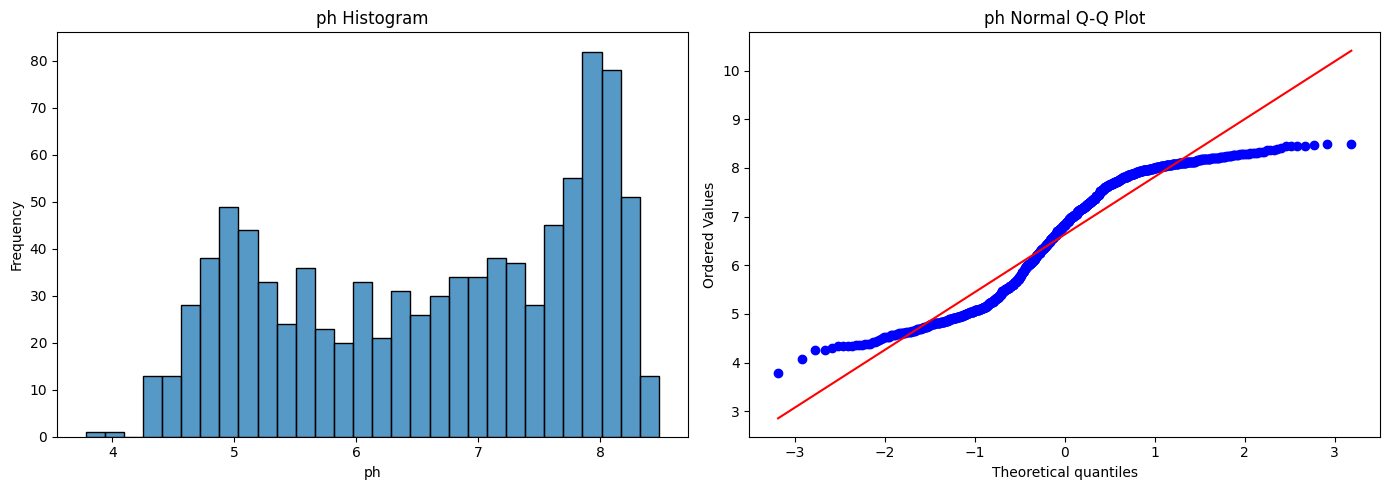

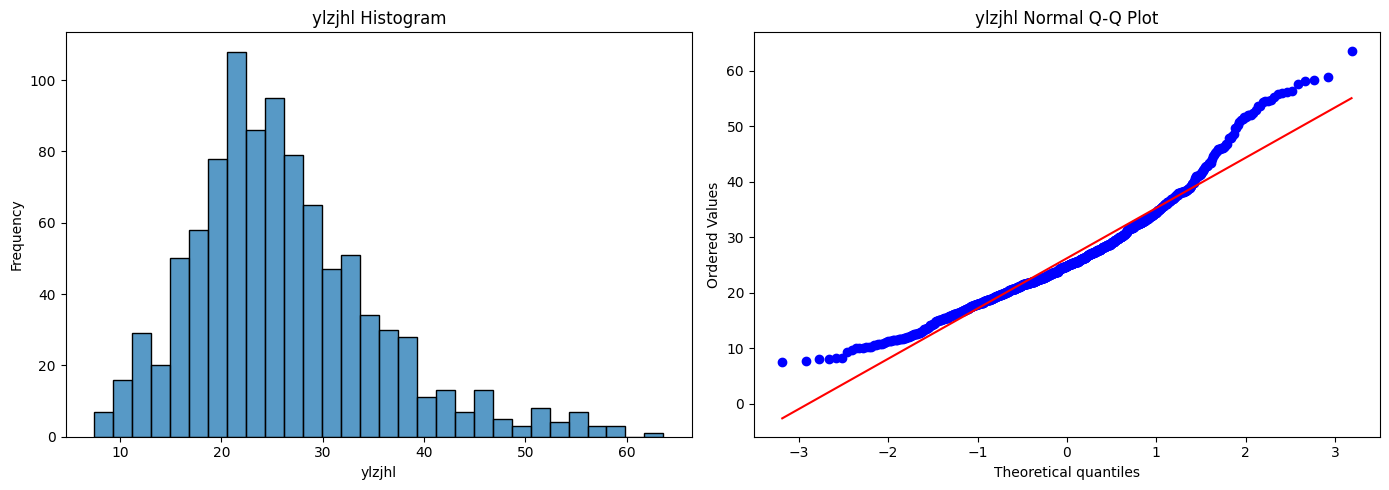

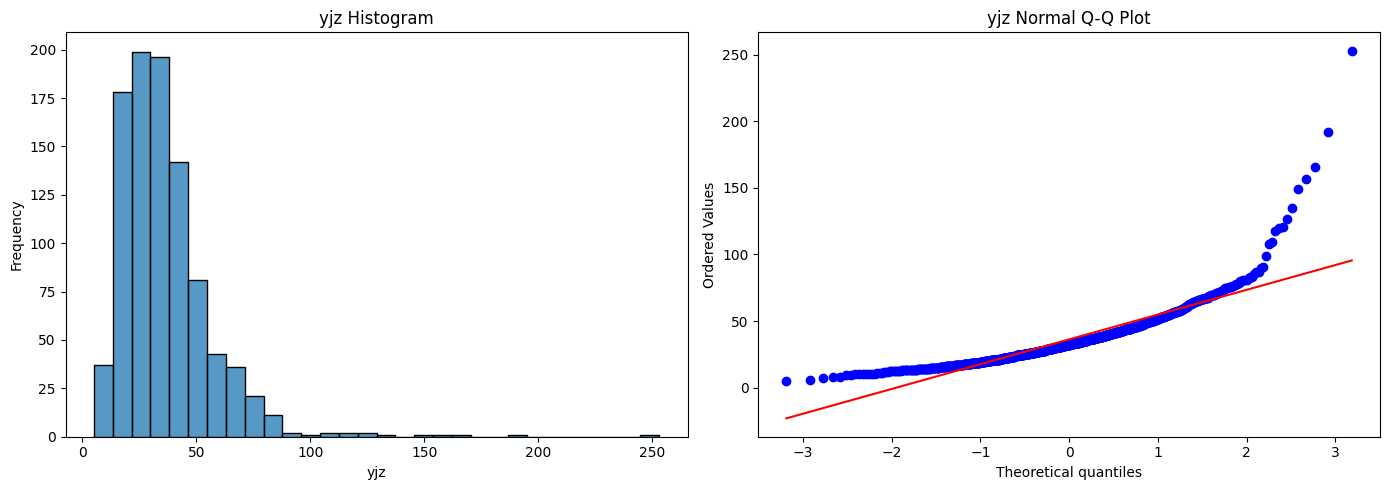

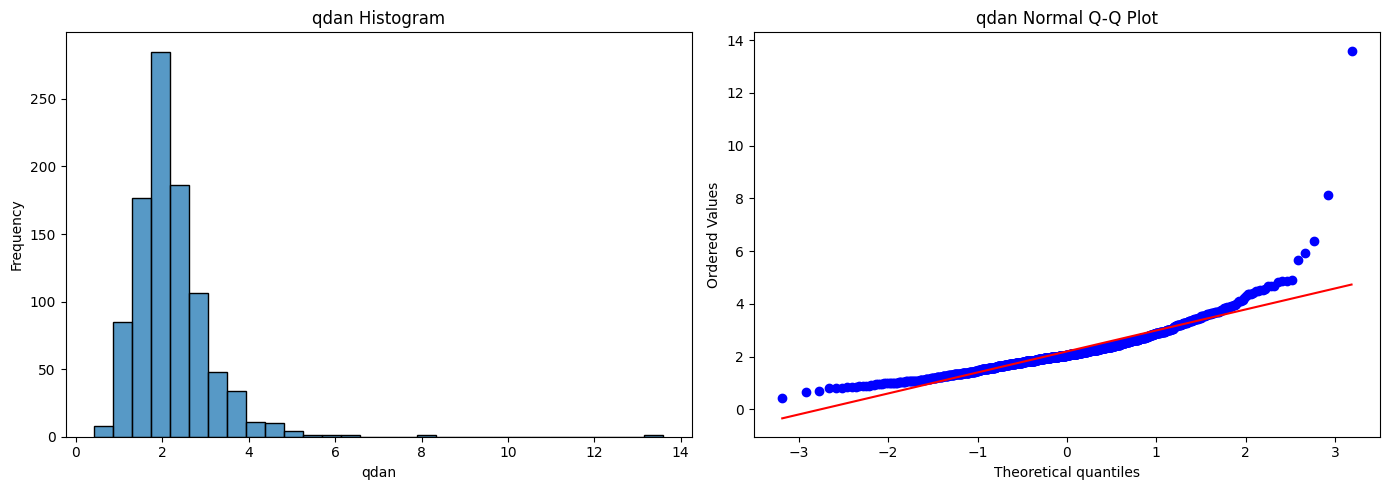

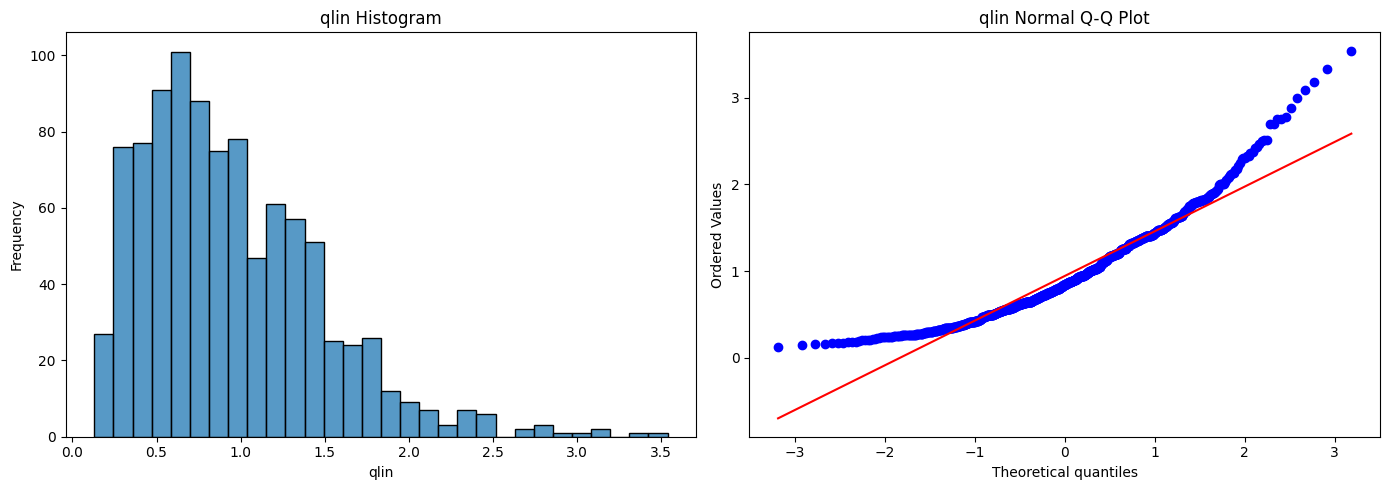

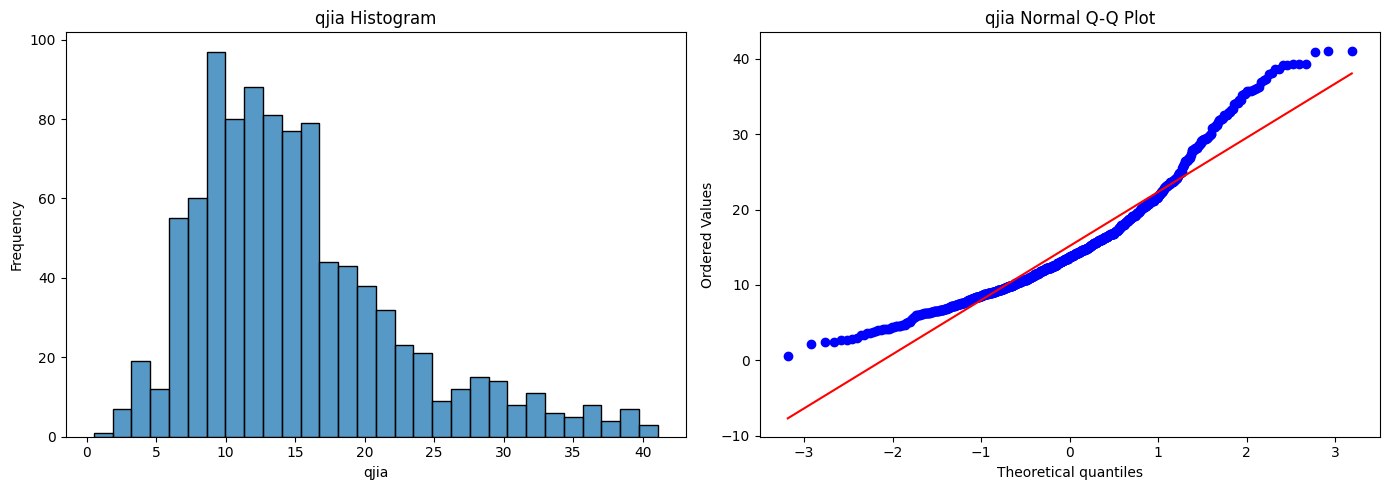

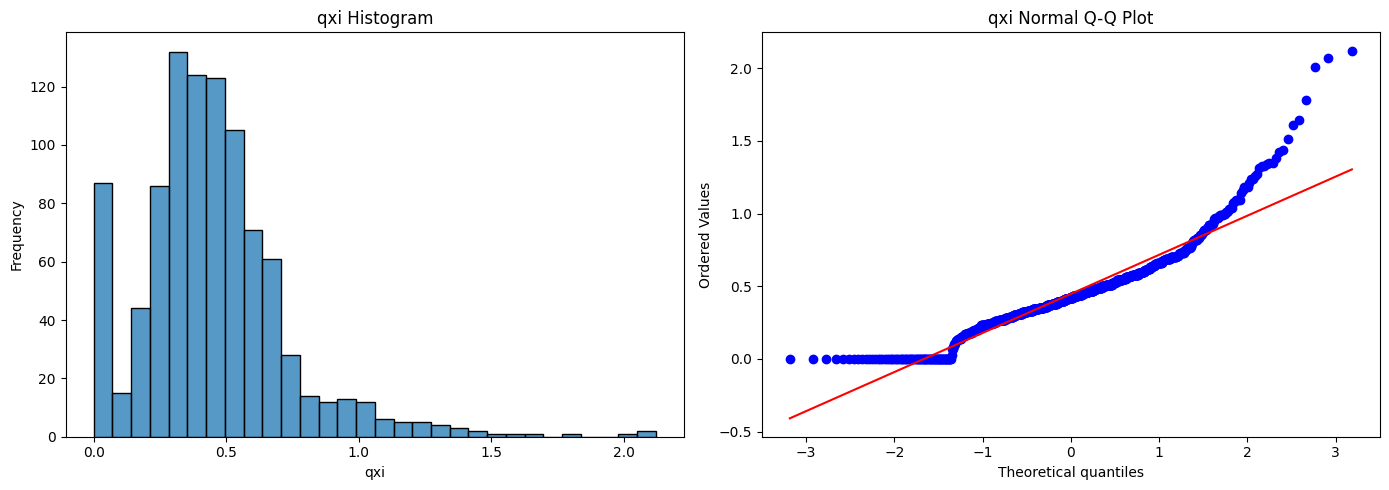

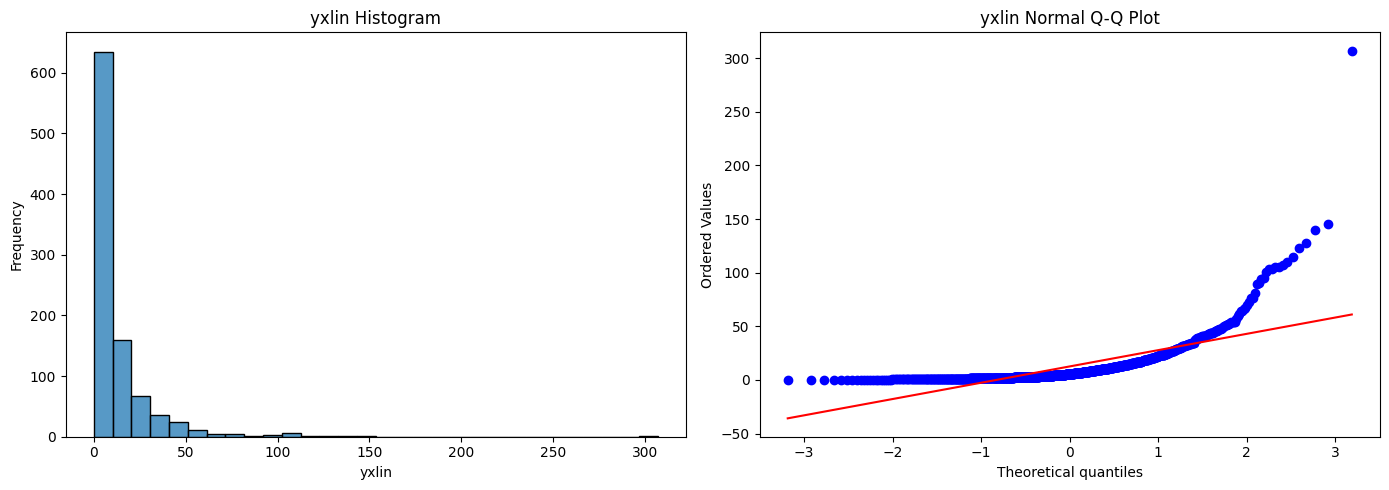

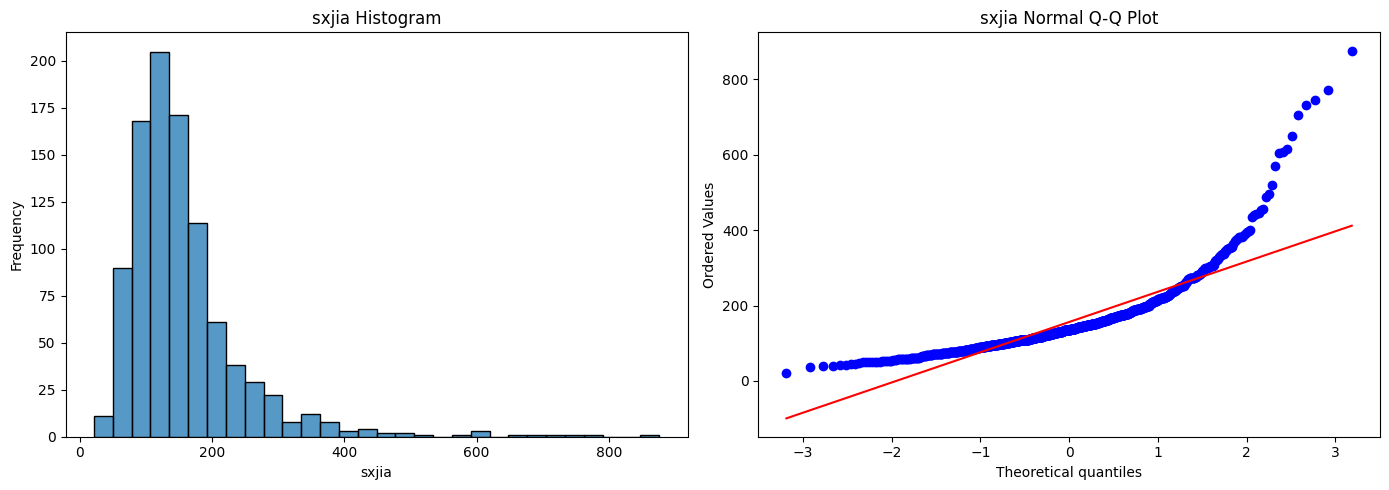

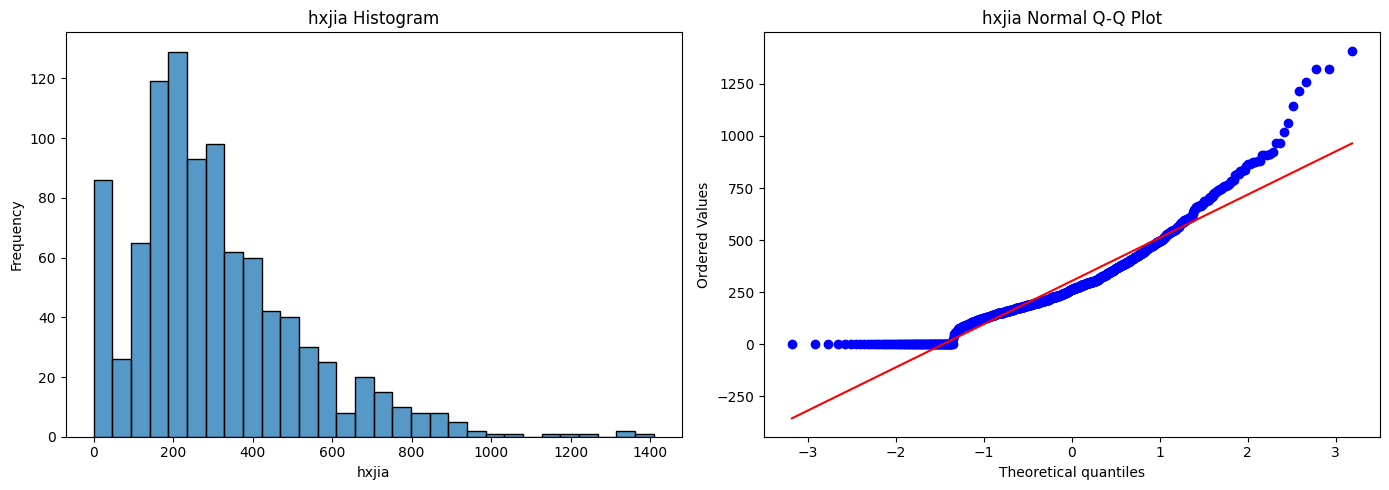

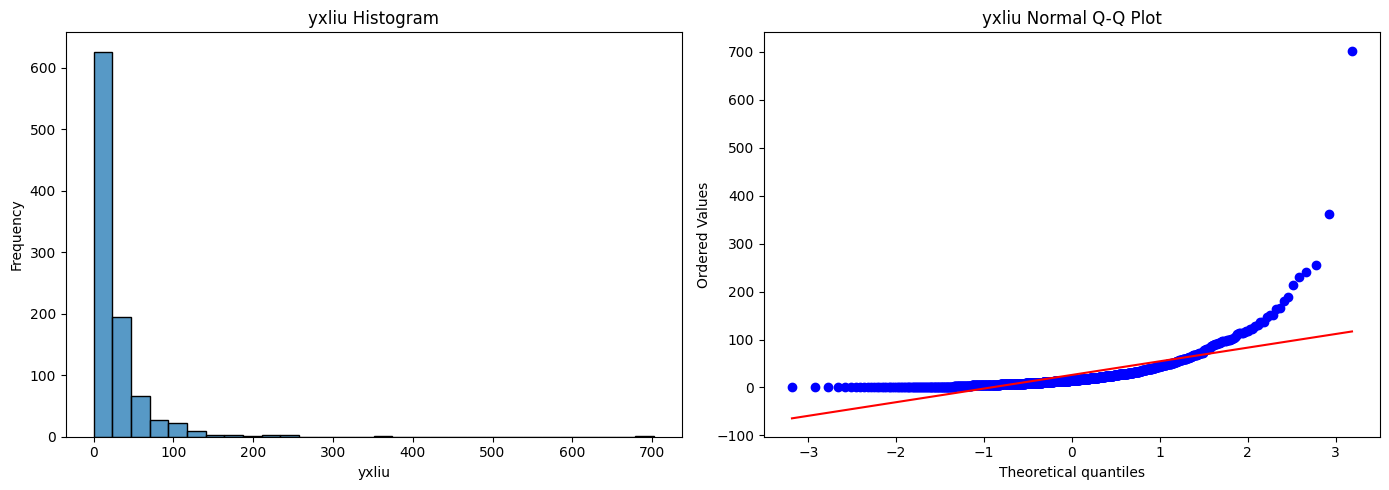

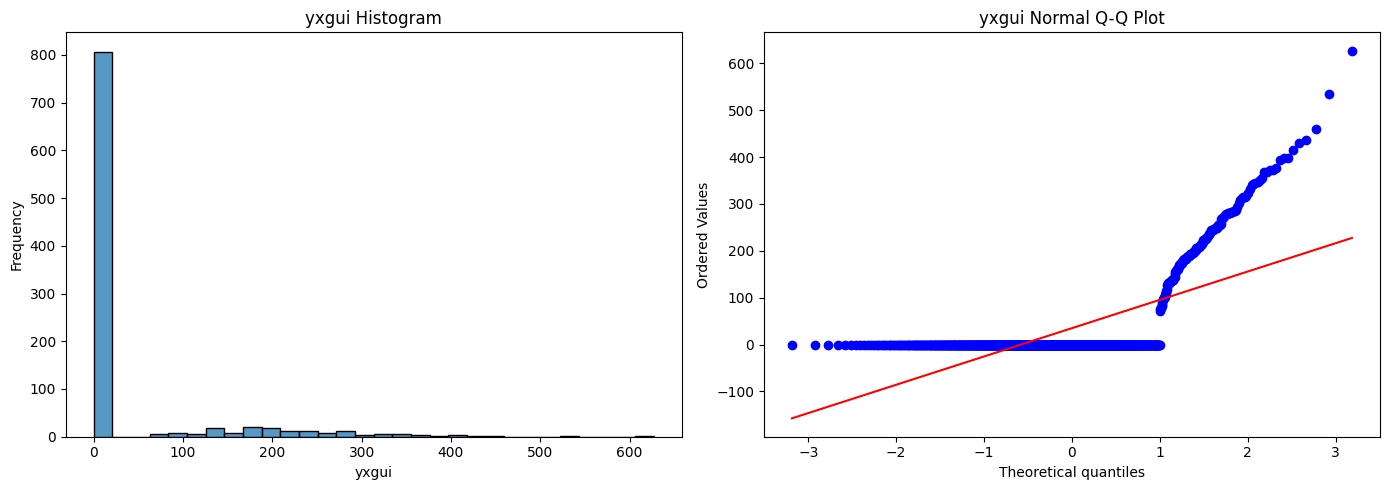

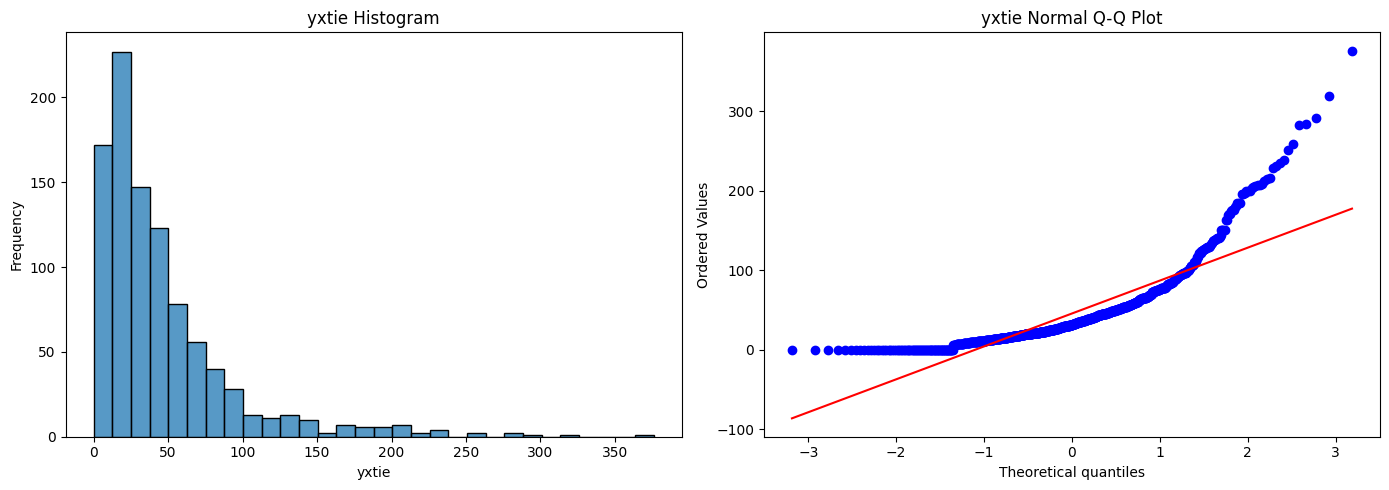

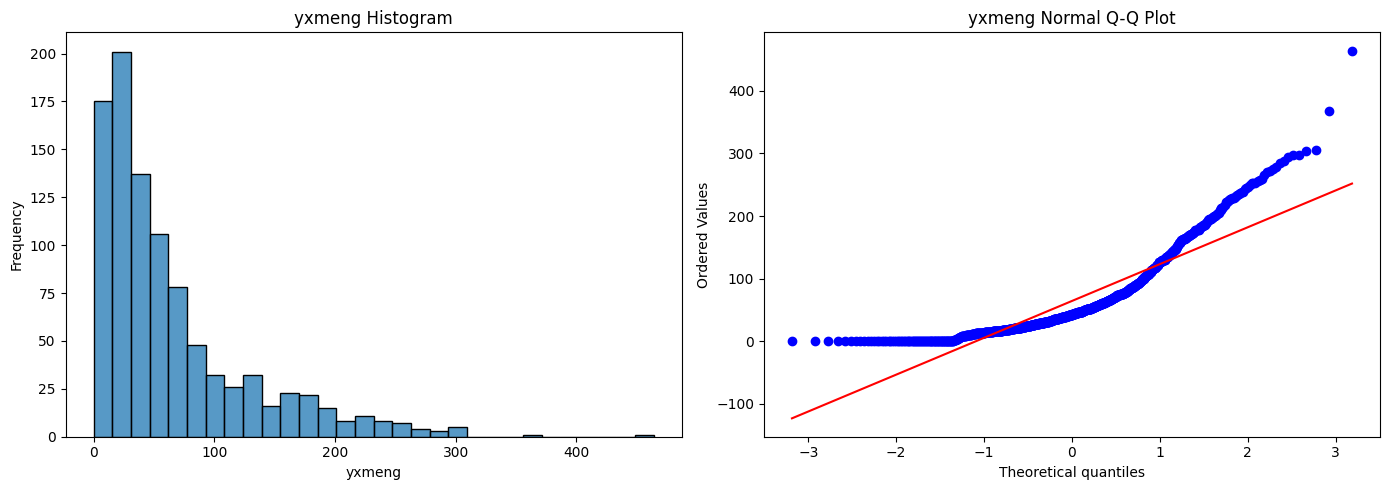

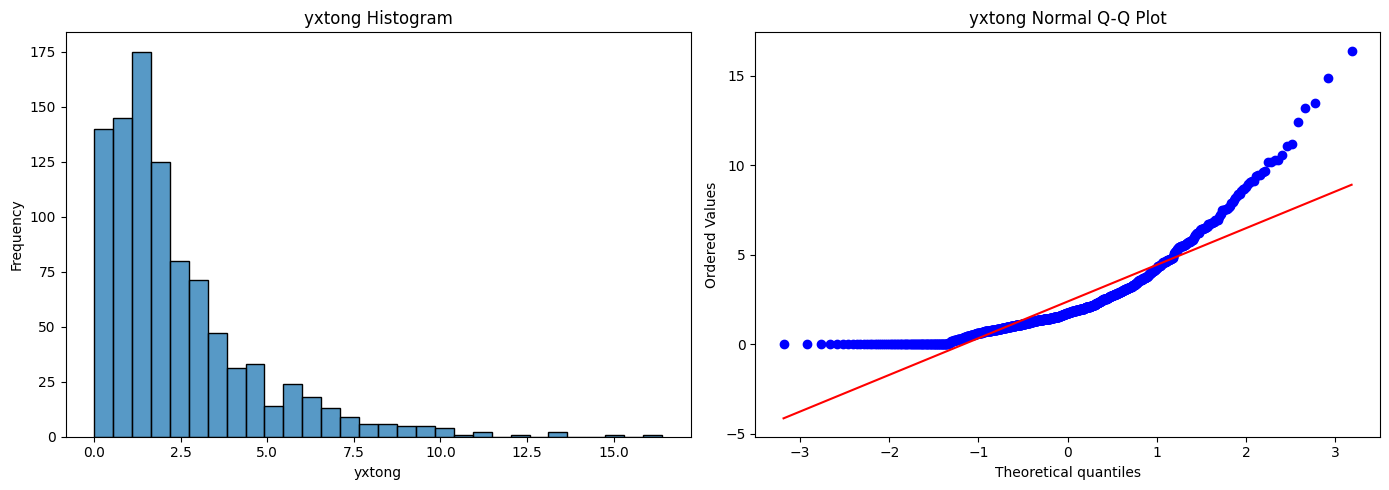

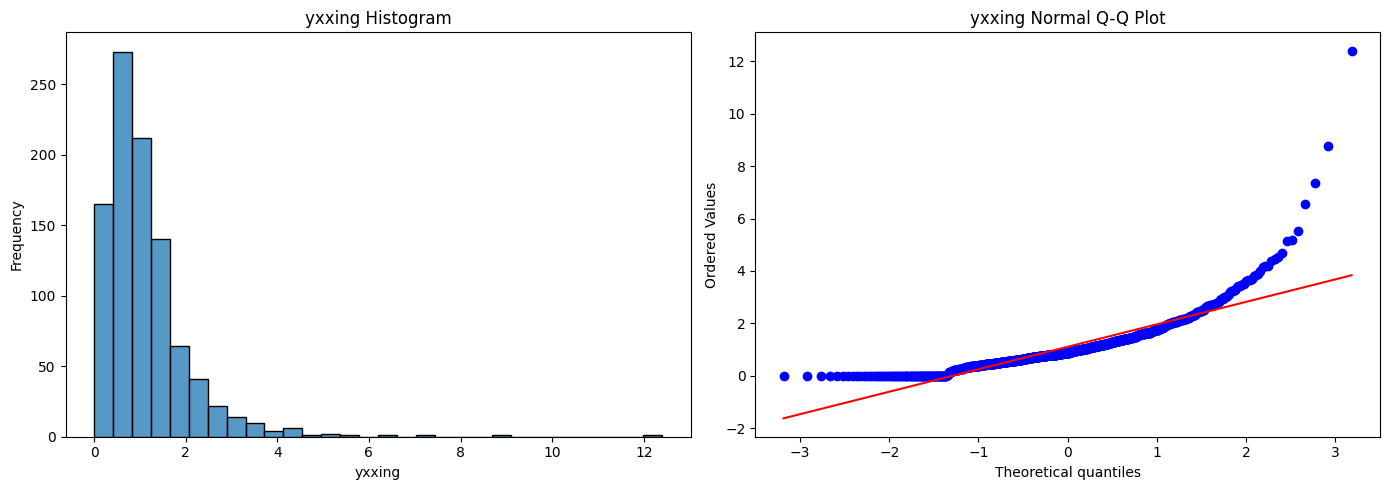

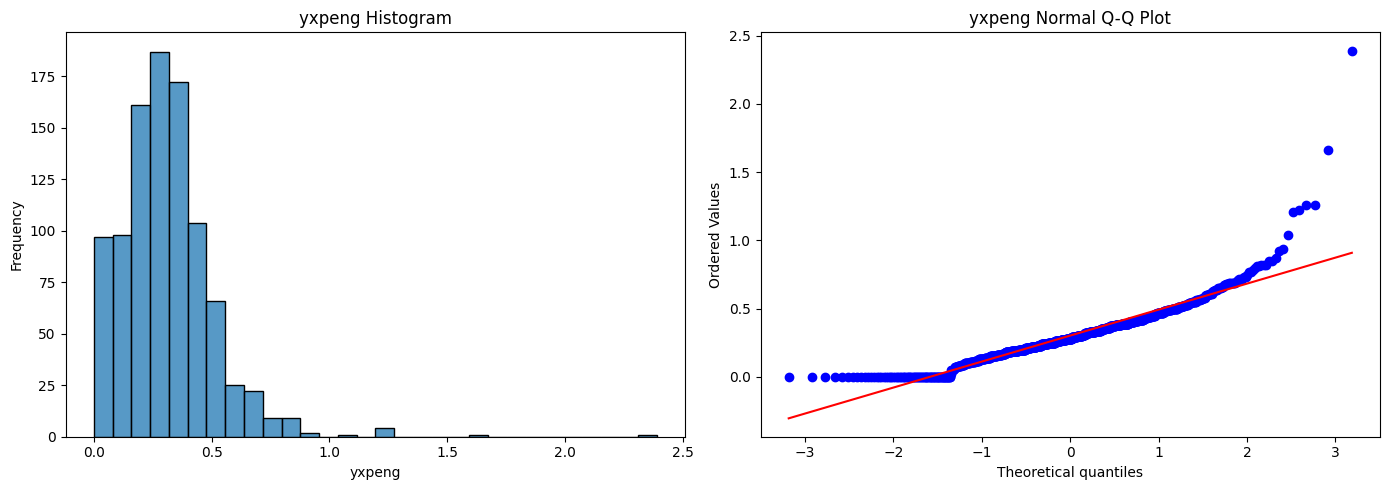

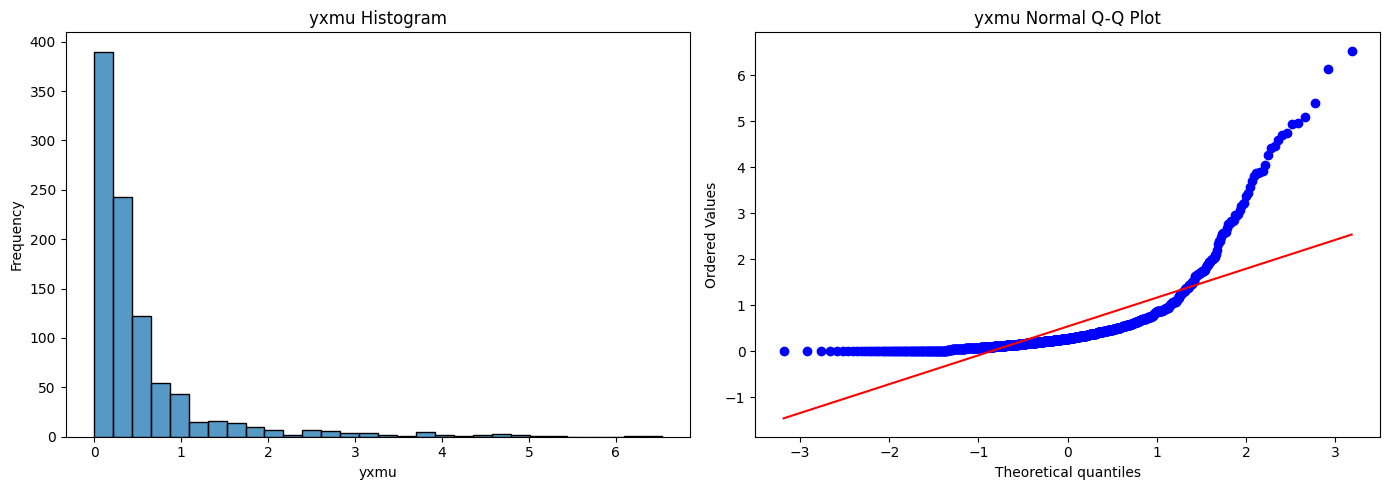

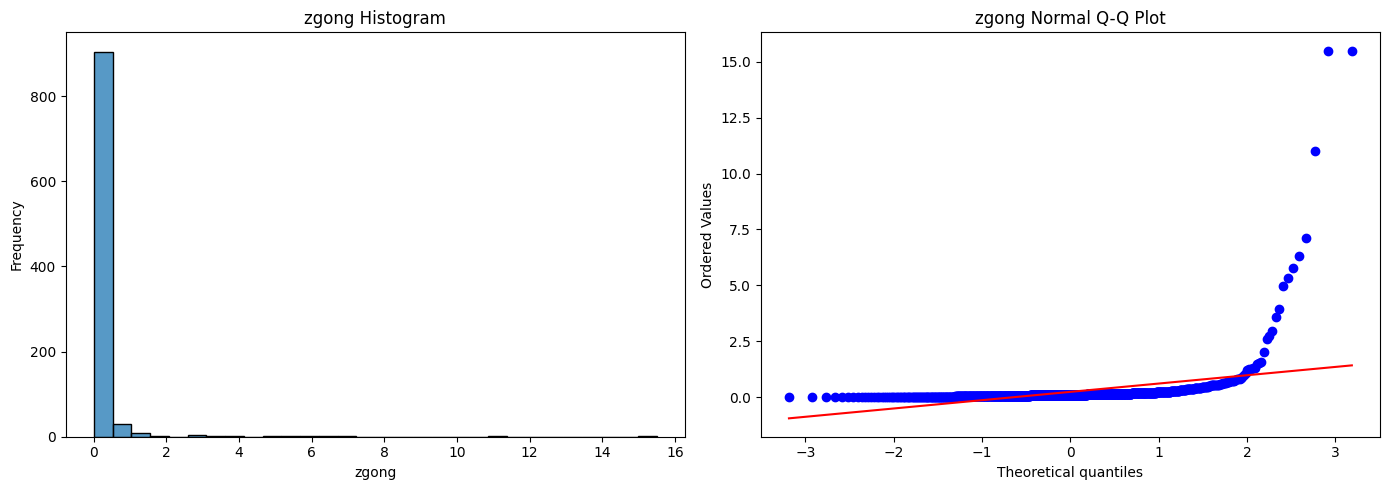

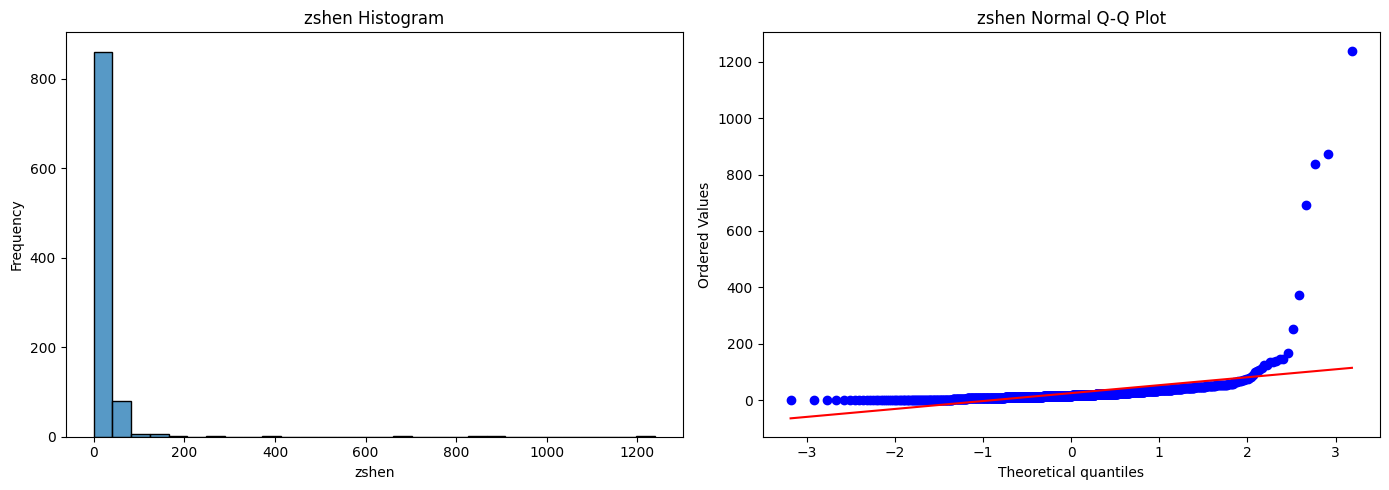

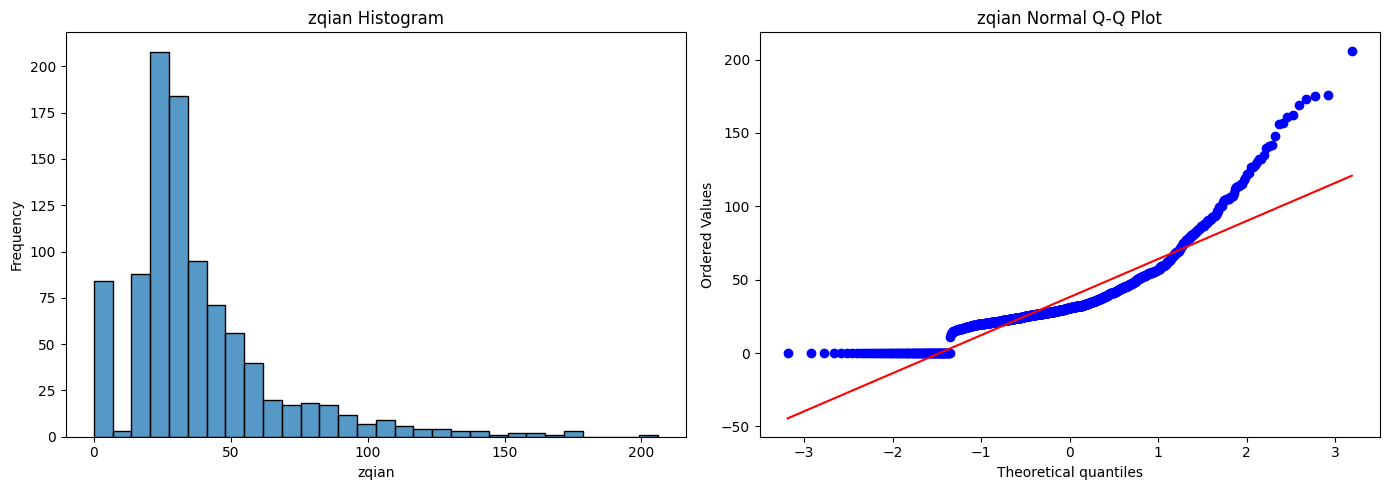

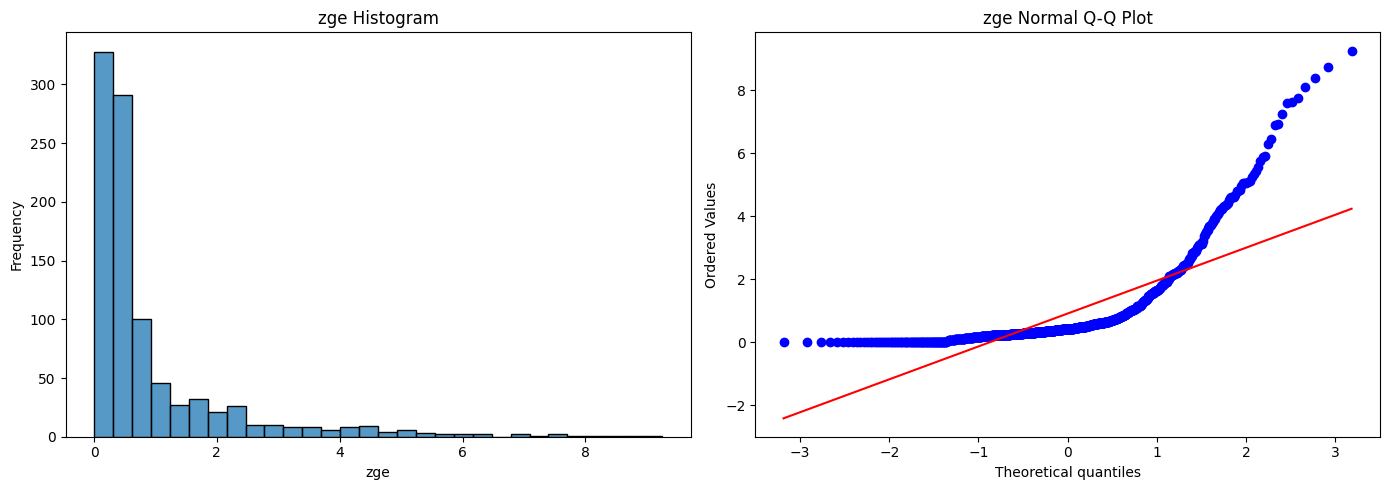

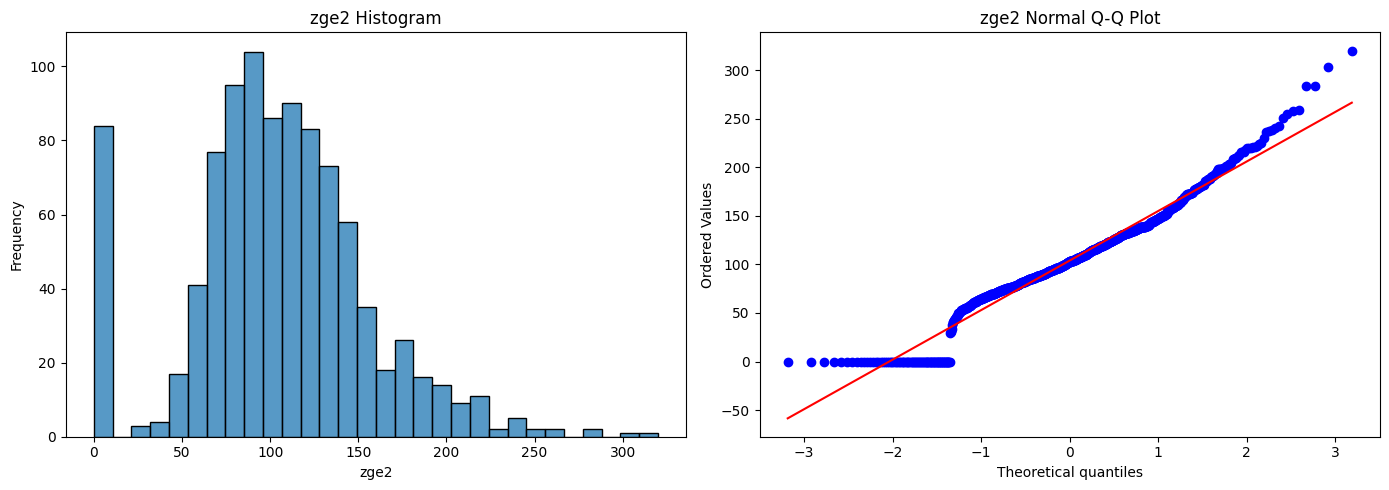

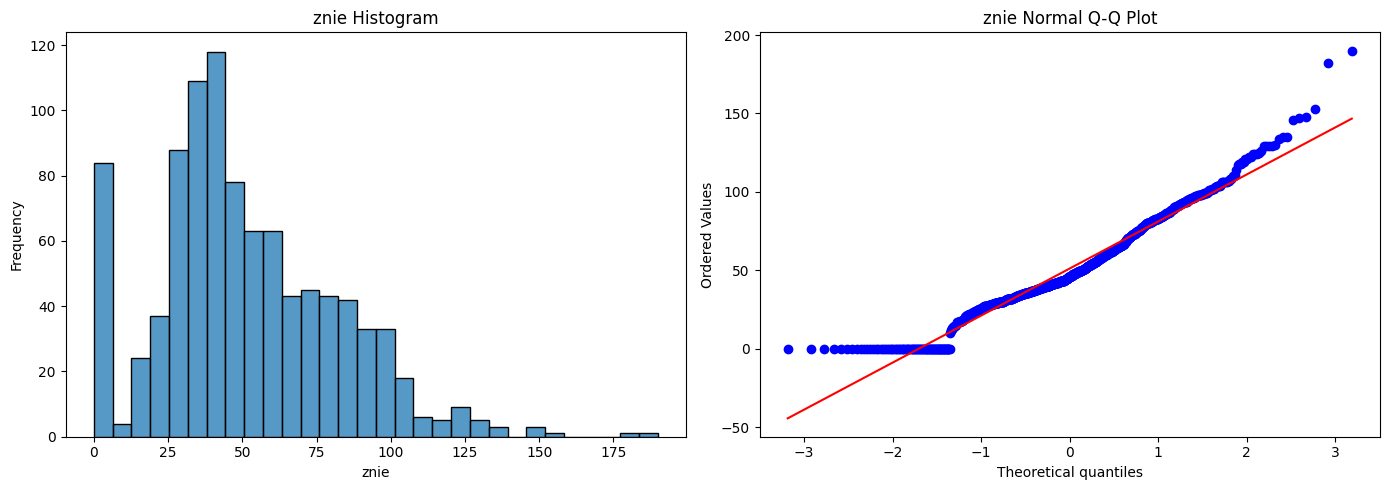

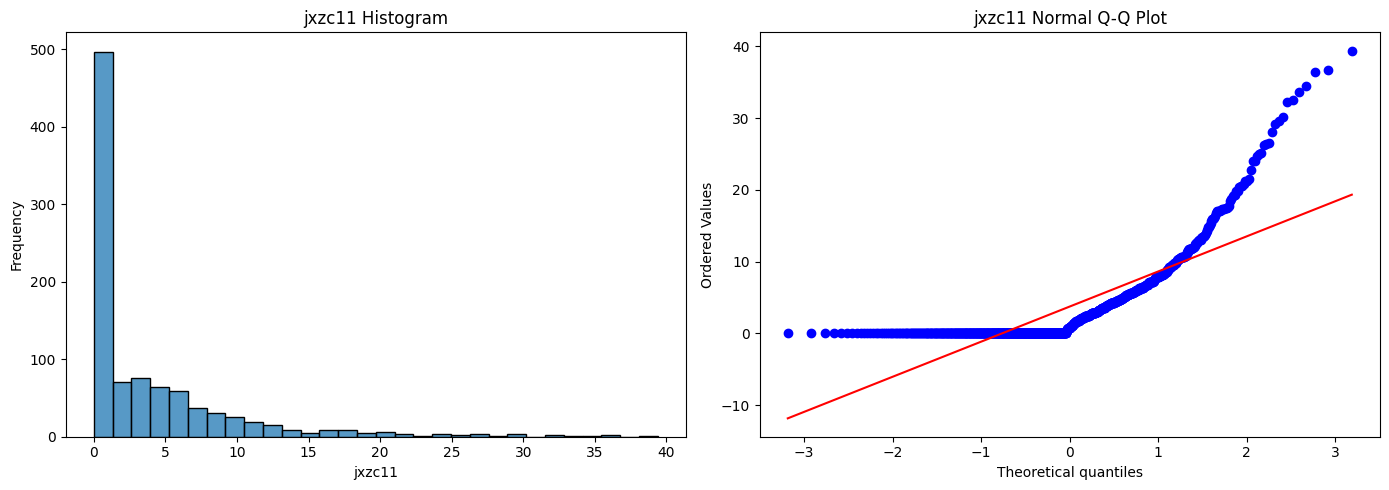

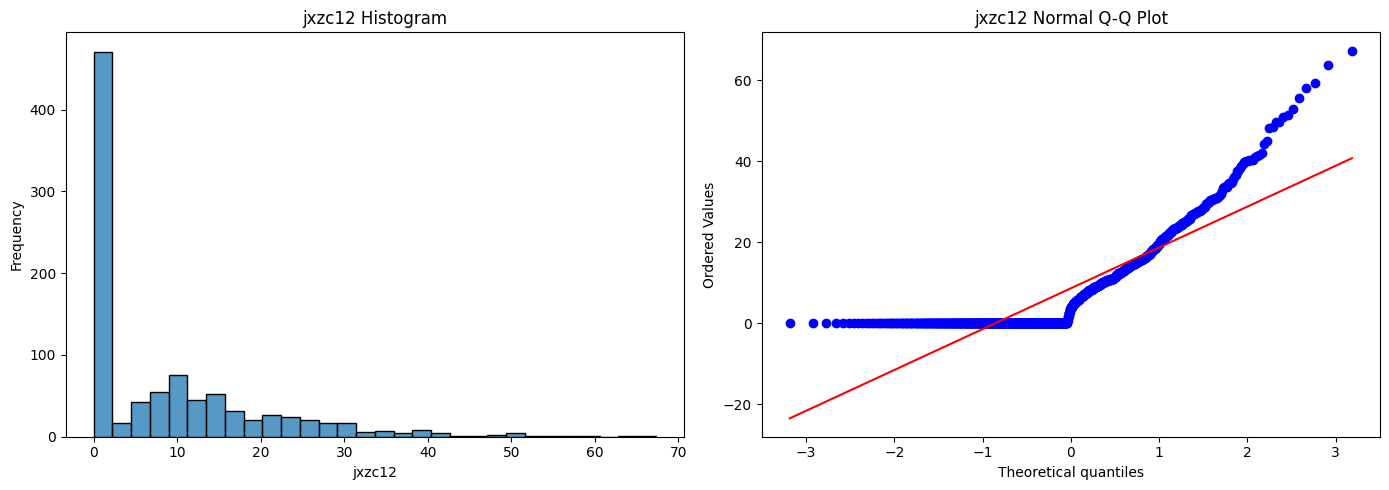

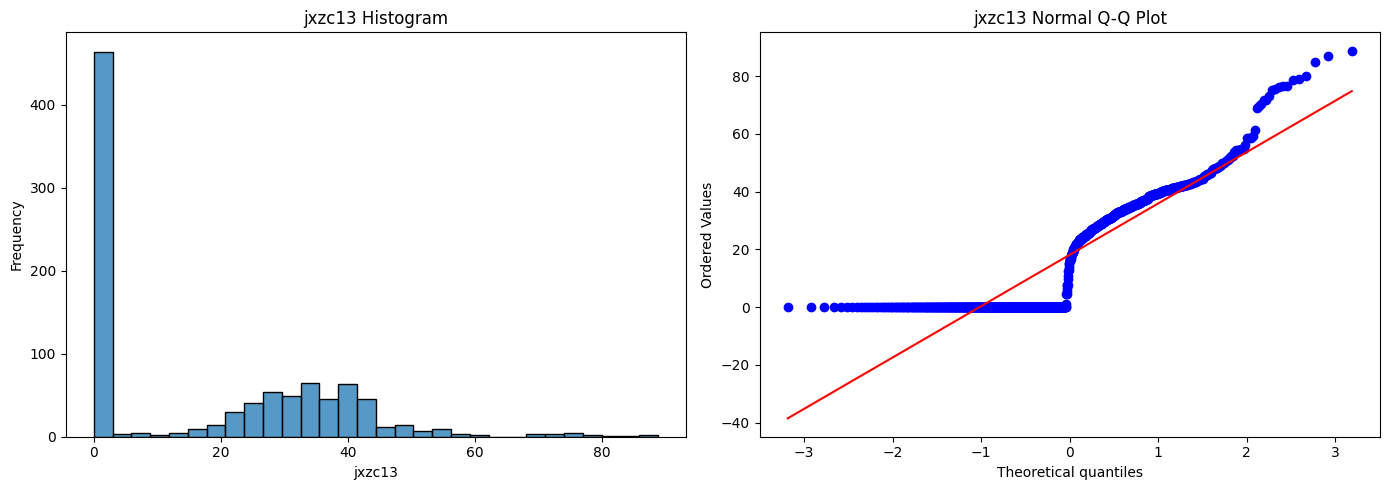

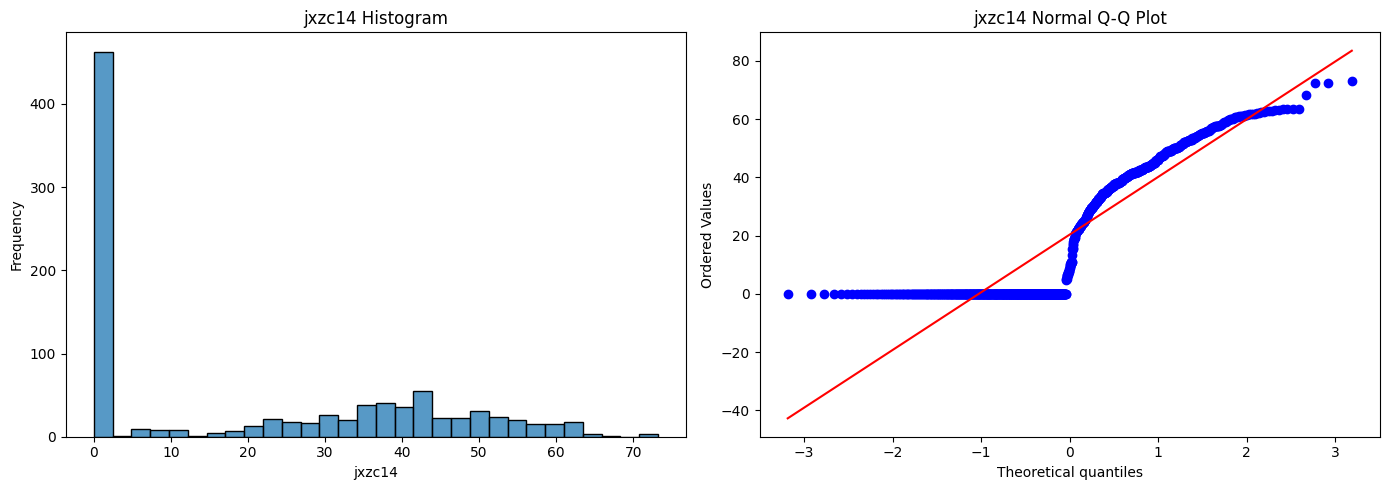

In [23]:
# 遍历df_result中的每一列
for column in result.columns[4:-1]:
    # 检查列的数据类型是否为数值型
    if pd.api.types.is_numeric_dtype(result[column]):
        # 创建一个图和两个子图
        fig, ax = plt.subplots(1, 2, figsize=(14, 5))

        # 在第一个子图上绘制直方图
        sns.histplot(result[column], kde=False, bins=30, ax=ax[0])
        ax[0].set_title(f'{column} Histogram')
        ax[0].set_xlabel(column)
        ax[0].set_ylabel('Frequency')

        # 在第二个子图上绘制正态分布检验图
        stats.probplot(result[column], plot=ax[1])
        ax[1].set_title(f'{column} Normal Q-Q Plot')

        # 调整布局并显示图
        plt.tight_layout()
        plt.show()
